# Input Preprocessing
Following: https://towardsdatascience.com/exploratory-data-analysis-for-natural-language-processing-ff0046ab3571

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Examining the data

In [2]:
# Getting and parsing the English dataset.
from ipynb.fs.full.parse_datasets import parse_datasets_language

data = parse_datasets_language("../datasets", "en")
all_tweets = pd.Series(data.iloc[:, 2:].values.flatten()) # pandas Series of all tweets

data.head(3)

,author_id,truth_value,tweet_1,tweet_2,tweet_3,tweet_4,tweet_5,tweet_6,tweet_7,tweet_8,...,tweet_91,tweet_92,tweet_93,tweet_94,tweet_95,tweet_96,tweet_97,tweet_98,tweet_99,tweet_100
0,06ct0t68y1acizh9eow3g5rhancrppr8,1,Courteney Cox Recreates Classic Friends Scene ...,The Jonas Brothers Have Secret Concert Days Af...,Ariana Grande Sends Heartfelt Message to Her F...,7 of the Biggest Bombshells From Jordyn Woods'...,Fyre Festival's Andy King Spills New Details o...,Watch Travis Scott Take an Adorable Phone Call...,See What Tyler Henry Really Thinks About His K...,Kim Kardashian Says She Had ''One of the Best ...,...,It's Pauly D Like You've Never Seen Him Before...,Hailey Baldwin Sends Her ''Lover'' Justin Bieb...,You Won't Believe How Much Money Property Brot...,"You Have to See Nicki Minaj's $450,000 Rolls-R...",How Maddie Poppe and Caleb Lee Hutchinson Are ...,What Do the Kids of the Grey's Anatomy Cast Th...,Inside Nikki Bella's Romantic Date Night With ...,How Justin Bieber Celebrated His 25th Birthday...,Matthew McConaughey's 3 Stylish Kids Make a Ra...,Royal Bartender! Kate Middleton Pours a Pint o...
1,071nxc49ihpd0jlfmvn2lghtayy3b5n9,0,Amber Smith “Kandy Halloween: Return of the Ha...,Kourtney Kardashian Reveals Scott Disick 'Chec...,Serena Williams Steps Out at the 2019 Met Gala...,See the campiest looks from 2019 Met Gala pink...,Trouble in Paradise? Kris Jenner and Corey Gam...,Bethenny Frankel Wants To Sell SkinnyGirl Beca...,Everything Kim Kardashian Has Said About Surro...,Kim Kardashian Confirms 4th Baby Not Here Yet ...,...,Michelle Williams Fuels Reconciliation Rumors ...,Dream Kardashian Flaunts Her Long Curly Locks ...,Charlize Theron Finally Addresses Her Rumored ...,Scott Disick Doesn’t Want To ‘Disrespect’ Sofi...,Kim Kardashian Lobbying for Systematic Change ...,Cardi B and Nicki Minaj Both Hit Met Gala Red ...,Jennifer Lopez and Alex Rodriguez Step Out for...,Jessie J Puts Her Misspelled Tattoo on Display...,Meghan Markle Gives Birth To Baby Boy! #URL#,Amy Schumer Cradles Up to Newborn Son Gene In ...
2,09py5qescynpnnckmzueqzr2y49moh1o,0,Rachel Bilson Was Asked Point-Blank if She’s D...,Bill Hader and Rachel Bilson make red carpet d...,What Do The Stars Say About Rachel Bilson? (12...,Celebrities front row at NYFW 2020 - Page Six ...,Rachel Bilson dating Bill Hader? - Arizona Dai...,Bill Hader and Rachel Bilson Confirm Relations...,How Did Rachel Bilson and Bill Hader Meet? - Y...,Rachel Bilson’s Golden Highlights Made For The...,...,Rachel Bilson On Helping La Marca Prosecco Lau...,Now This Is an Unexpected Couple - The Cut #UR...,"Love That O.C. Reunion Pic? Well, We've Got So...",Is Rachel Bilson Loved or Hated? New Analysis ...,Never Forget When Bill Hader Parodied Rachel B...,Bill Hader and Rachel Bilson made their red ca...,Rachel Bilson shops for home furnishings and g...,"Hold Up, Are Rachel Bilson and Bill Hader a Co...","Bill Hader, Rachel Bilson continue to fuel rum...",New couple alert! Bill Hader takes Rachel Bils...


### Number of characters per tweet
Below we can see that tweet length varies greatly, between 22 and 152 characters.

Min: 22 , Max: 152


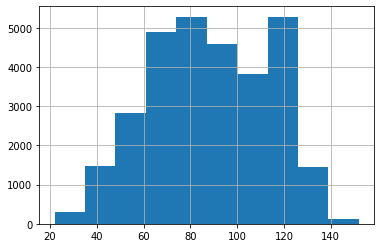

In [3]:
lengths = all_tweets.str.len()
lengths.hist()
print("Min:", min(lengths), ", Max:", max(lengths))

### Number of words per tweet

Min: 6 , Max: 30


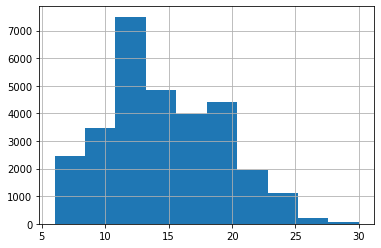

In [4]:
words = all_tweets.str.split().map(lambda x: len(x))
words.hist()
print("Min:", min(words), ", Max:", max(words))

## Preprocessing

In [5]:
import string
import demoji
from unidecode import unidecode
from bs4 import BeautifulSoup
from xml.sax.saxutils import unescape
from sklearn.model_selection import train_test_split

In [6]:
class InputPreprocessor:
    def __init__(self, tweets, labels):
        """
        Constructs a new InputPreprocessor object.
        
        :param tweets: A Pandas DataFrame where each row represents a tweet feed and columns 
        are labelled 'Tweet 1' to 'Tweet 100'.
        :param labels: A Pandas Series of the Fake News labels, where each row corresponds to 
        the same indexed row in 'tweets'.
        """
        self.tweets = tweets.copy()
        self.labels = labels.copy()
    
    def preprocess(self):
        # Replace XML encodings - &amp; &lt; &gt;
        # Then remove HTML tags - <br>
        def replace_xml_and_html(tweet):
            replace_xml = unescape(tweet)
            replace_html = BeautifulSoup(replace_xml).get_text()
            return replace_html

        # Remove punctuation, apart from '#'
        def remove_punctuation(tweet):
            punc = set(string.punctuation)
            prin = set(string.printable)
            punc.remove('#')
            return ''.join(c for c in tweet if c not in punc and c in prin)

        # Replace emojis with their meaning, e.g. :smiling_face:
        def replace_emojis(tweet):
            return demoji.replace_with_desc(tweet, ':')

        # Replace #HASHTAG# and #URL# #USER# with tags [tag] and [url], [user]
        def replace_tags(tweet):
            tweet = tweet.replace('#HASHTAG#', '[tag]')
            tweet = tweet.replace('#URL#', '[url]')
            tweet = tweet.replace('#USER#', '[user]')
            return tweet

        # Remove '#'s
        def remove_hashtag_chars(tweet):
            return ''.join(c for c in tweet if c != '#')

        def replace_accented_chars(tweet):
            return unidecode(tweet)

        def remove_extra_spacing(tweet):
            return ' '.join(tweet.split())
        
        preprocess_funcs = [
            replace_xml_and_html, 
            replace_emojis, 
            remove_punctuation,
            replace_tags, 
            remove_hashtag_chars, 
            replace_accented_chars, 
            remove_extra_spacing
        ]
        
        # Process a column of tweets
        def process_col(col):
            for i in range(len(col)):
                col[i] = process_tweet(col[i])

            return col
        
        # Process an individual tweet
        def process_tweet(tweet):
            for f in preprocess_funcs:
                tweet = f(tweet)

            return tweet
        
        self.tweets.apply(process_col)
        
    def to_individual_tweets_dataset(self):
        """
        :return: train, validation, test numpy array splits of the dataset, where the tweet 
        columns have been joined to create one column, and the labels expanded to match this.
        """
        tweets = np.asarray([tweet for row in self.tweets.values for tweet in row])
        labels = np.asarray([label for label in self.labels.values for i in range(100)])
        return self.split_dataset(tweets, labels)
    
    def to_tweet_feed_dataset(self):
        """
        :return: train, validation, test numpy array splits of the dataset, where all of the 
        tweets for each user have been concatenated into one string.
        """
        tweets = np.asarray(self.tweets.agg(' '.join, axis=1))
        labels = np.asarray(self.labels)
        return self.split_dataset(tweets, labels)
    
    def split_dataset(self, tweets, labels):
        tweet_train, tweet_other, label_train, label_other = \
            train_test_split(tweets, labels, test_size=0.3)
        tweet_val, tweet_test, label_val, label_test = \
            train_test_split(tweet_other, label_other, test_size=0.5)
        
        return (tweet_train, label_train, tweet_val, label_val, tweet_test, label_test)

# Preprocessing for BERT

In [7]:
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.layers import Dense, Input, LSTM, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from official.nlp.bert import tokenization

import numpy as np

In [21]:
class BertModel():
    def __init__(self, encoder_url, bert_input_size, encoding):
        # Get BERT encoder and tokenizer
        self.encoder = hub.KerasLayer(encoder_url, trainable=True)
        self.bert_input_size = bert_input_size
        self.encoding = encoding
        self.tokenizer = tokenization.FullTokenizer(
            self.encoder.resolved_object.vocab_file.asset_path.numpy(), 
            do_lower_case=self.encoder.resolved_object.do_lower_case.numpy())
        
    def compile(self, optimizer, loss, metrics):
        inputs = self.compile_inputs()
        
        # Get the BERT pooled output
        encoder_pooled_output = self.encoder(inputs)['pooled_output']
        
        # Get the Dense layer output
        dense_output = Dense(1, activation='sigmoid')(encoder_pooled_output)
        
        # Create the Keras model and compile
        self.model = Model(inputs, dense_output)
        self.model.compile(optimizer, loss, metrics)
    
    def compile_inputs(self):
        # Create BERT Input layers
        def input_layer(input_name):
            return Input(shape=(self.bert_input_size,), dtype=tf.int32, name=input_name)
        
        return dict(
            input_word_ids=input_layer("inputs/input_word_ids"),
            input_mask=input_layer("inputs/input_mask"),
            input_type_ids=input_layer("inputs/input_type_ids"))
    
    # Removes the Dense output layer - TODO - check that this keeps the weights of the trained model.
    def to_plain_bert_model(self):
        inputs = self.compile_inputs()
        encoder_pooled_output = self.encoder(inputs)['pooled_output']
        self.model = Model(inputs, encoder_pooled_output)
    
    def to_test(self):
        inputs = self.compile_inputs()
        encoder_pooled_output = self.encoder(inputs)
        self.model = Model(inputs, encoder_pooled_output)
        
    def fit(self, x, y, batch_size=None, epochs=1, callbacks=None, validation_data=None):
        print('Encoding input data')
        x_encoded, y_encoded = self.encode_input(x), self.encode_labels(y)
        
        if (validation_data != None):
            validation_data = (
                self.encode_input(validation_data[0]), 
                self.encode_labels(validation_data[1]))
        
        print('Fitting BERTModel')
        return self.model.fit(
            x=x_encoded, 
            y=y_encoded, 
            batch_size=batch_size, 
            epochs=epochs,
            callbacks=callbacks,
            validation_data=validation_data)
        
    def predict(self, x):
        print('Predicting using BERTModel')
        
        if (self.encoding == 'individual'):
            # TODO - unsure if this is correct.
            x_encoded = self.encode_input(x)
            return self.model.predict(x_encoded)
        
        elif (self.encoding == 'feed'):
            result = []
            for tweet_feed in x:
                x_encoded = self.encode_input([tweet_feed])
                prediction = self.model.predict(x_encoded)
                result.append(prediction)
            
            # Returns (n, k, 768) array, where k is the number of chunks (variable),
            # n is the number of tweet feeds (input size), and 768 is BERT's hidden layer size.
            return np.asarray(result)

    def evaluate(self, x, y, batch_size=32):
        x_encoded, y_encoded = self.encode_input(x), self.encode_labels(y)
        return self.model.evaluate(
            x_encoded, 
            y_encoded, 
            batch_size)
    
    def encode_input(self, x): # x should always be a list or array!
        # Encode tweets
        def encode_tweet(tweet):
            tokens = self.tokenizer.tokenize(tweet)[:self.bert_input_size-2]
            tokens.append('[SEP]')
            tokens.insert(0, '[CLS]')
            return self.tokenizer.convert_tokens_to_ids(tokens)
        
        # Encode tweet feed into chunks
        def encode_tweet_feed(tweet_feed):
            feed_tokens = self.tokenizer.tokenize(tweet_feed)
            tokens = [feed_tokens[i:i+self.bert_input_size-2]
                      for i in range(0, len(feed_tokens), self.bert_input_size-52)]
#             tokens[-1] = feed_tokens[len(feed_tokens)-self.bert_input_size+2:len(feed_tokens)] # Remove? - fills the last chunk
            
            def encode_tokens(tokens):
                tokens.append('[SEP]')
                tokens.insert(0, '[CLS]')
                return self.tokenizer.convert_tokens_to_ids(tokens)
            
            return list(map(encode_tokens, tokens))
        
        if (self.encoding == 'individual'):
            input_word_ids = tf.ragged.constant([encode_tweet(tweet) for tweet in x])
            
        elif (self.encoding == 'feed'):
            encoded_tweet_feed = [encode_tweet_feed(tweet_feed) for tweet_feed in x]
            input_word_ids = tf.ragged.constant(
                [tweet for tweet_feed in encoded_tweet_feed for tweet in tweet_feed])
            self.y_pattern = [len(tweet_feed) for tweet_feed in encoded_tweet_feed]
        
        input_mask = tf.ones_like(input_word_ids)
        
        # Pad word_ids and mask
        input_word_ids = input_word_ids.to_tensor()
        input_mask = input_mask.to_tensor()
        
        padding = tf.constant([[0, 0,], [0, (self.bert_input_size - input_mask.shape[1])]])
        input_word_ids = tf.pad(input_word_ids, padding, "CONSTANT")
        input_mask = tf.pad(input_mask, padding, "CONSTANT")
        
        input_type_ids = tf.zeros_like(input_mask)
        
        # Return encoded inputs
        x_encoded = dict(
            input_word_ids=input_word_ids,
            input_mask=input_mask,
            input_type_ids=input_type_ids)
    
        return x_encoded
    
    def encode_labels(self, y):
        if (self.encoding == 'individual'):
            return tf.convert_to_tensor(y, tf.int32)
        elif (self.encoding == 'feed'):
            return tf.convert_to_tensor(
                [int(v) for v,n in zip(y, self.y_pattern) for i in range(n)], 
                tf.int32)

In [22]:
# Create a BertModel object
bert_model = BertModel(
    "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3",
    500,
    "feed")

In [23]:
# Compile the model optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy']
bert_model.compile(Adam(lr=1e-5), 'binary_crossentropy', ['accuracy'])

# Set the checkpoint path for saving/loading weights
checkpoint_path = "training/bert_training_1/cp.ckpt"

In [24]:
# Load the models saved weights
bert_model.model.load_weights(checkpoint_path)

In [12]:
bert_model.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs/input_mask (InputLayer)  [(None, 500)]        0                                            
__________________________________________________________________________________________________
inputs/input_type_ids (InputLay [(None, 500)]        0                                            
__________________________________________________________________________________________________
inputs/input_word_ids (InputLay [(None, 500)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'default': (None, 7 108310273   inputs/input_mask[0][0]          
                                                                 inputs/input_type_ids[

In [13]:
# Preprocess the input dataset in tweet-feed format
data_copy = data.copy()

data_preprocessor = InputPreprocessor(data_copy.iloc[:, 2:], data_copy.iloc[:, 1])
data_preprocessor.preprocess()

tweet_train, label_train, tweet_val, label_val, tweet_test, label_test = \
    data_preprocessor.to_tweet_feed_dataset()

In [14]:
# Create a checkpoint for training BERTModel
bert_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1)

In [25]:
bert_model.to_test()

In [28]:
res = bert_model.predict([tweet_test[1]])[0]

Predicting using BERTModel


In [37]:
for k,v in res.items():
    print(k, type(v))

default <class 'numpy.ndarray'>
encoder_outputs <class 'list'>
pooled_output <class 'numpy.ndarray'>
sequence_output <class 'numpy.ndarray'>


In [39]:
print("sequence_output", res['sequence_output'].shape)
print("pooled_output", res['pooled_output'].shape)
print("default", res['default'].shape)
print("encoder_outputs", len(res['encoder_outputs']))

sequence_output (5, 500, 768)
pooled_output (5, 768)
default (5, 768)
encoder_outputs 12


In [186]:
# Fit BERTModel using the training and validation data
# bert_model.fit(
#     x=tweet_train, 
#     y=label_train, 
#     batch_size=20, 
#     epochs=5, 
#     callbacks=[bert_checkpoint_callback],
#     validation_data=(tweet_val, label_val))

Encoding input data
Fitting BERTModel
Epoch 1/5
62/62 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.5878  
Epoch 00001: saving model to training/bert_training_1\cp.ckpt
62/62 [==============================] - 4397s 71s/step - loss: 0.6883 - accuracy: 0.5878 - val_loss: 0.6342 - val_accuracy: 0.6604
Epoch 2/5
62/62 [==============================] - ETA: 0s - loss: 0.5318 - accuracy: 0.7309  
Epoch 00002: saving model to training/bert_training_1\cp.ckpt
62/62 [==============================] - 4366s 70s/step - loss: 0.5318 - accuracy: 0.7309 - val_loss: 0.6193 - val_accuracy: 0.6566
Epoch 3/5
62/62 [==============================] - ETA: 0s - loss: 0.3862 - accuracy: 0.8423  
Epoch 00003: saving model to training/bert_training_1\cp.ckpt
62/62 [==============================] - 4359s 70s/step - loss: 0.3862 - accuracy: 0.8423 - val_loss: 0.6692 - val_accuracy: 0.6755
Epoch 4/5
62/62 [==============================] - ETA: 0s - loss: 0.2510 - accuracy: 0.9033  


In [187]:
# Evaluate the BERT Model on the test set
bert_model.evaluate(tweet_test, label_test, batch_size=20)

14/14 [==============================] - 158s 11s/step - loss: 0.8744 - accuracy: 0.7088


[0.874427080154419, 0.7088122367858887]

In [270]:
pred = bert_model.predict(tweet_test)

Predicting using BERTModel


In [281]:
classifications = [(0 if i.mean() < 0.5 else 1) for i in pred]

tp, fn, tn, fp = 0, 0, 0, 0
for c,p in zip(classifications, tf.convert_to_tensor(label_test, tf.int32)):
    if (c == 0 and p == 0):
        tp += 1
    elif (c == 1 and p == 0):
        fn += 1
    elif (c == 1 and p == 1):
        tn += 1
    elif (c == 0 and p == 1):
        fp += 1

In [282]:
print("Accuracy:", (tp+tn)/(tp+tn+fp+fn))

Accuracy: 0.6888888888888889


In [238]:
# Output from BERTModel is max-pooled (max taken of each column)
# Then put into a Dense layer with Sigmoid applied
class BertMaxPoolingModel():
    def __init__(self, bert_model, bert_checkpoint_path=None):
        self.bert_model = bert_model
        self.bert_model.to_plain_bert_model()
        if (bert_checkpoint_path != None):
            self.bert_model.model.load_weights(bert_checkpoint_path)
    
    def compile(self, optimizer, loss, metrics):
        bert_output_len = self.bert_model.model.layers[-1].output_shape['pooled_output'][1]
        encoder_pooled_output = Input(
            shape=(bert_output_len, ), 
            dtype=tf.int32,
            name='Max_pooling_out')
        
        # Dense layer is 768 (input) to 1 (output)
        dense_output = Dense(1, activation='sigmoid')(encoder_pooled_output)
        
        # Create the Keras model and compile
        self.model = Model(encoder_pooled_output, dense_output)
        self.model.compile(optimizer, loss, metrics)
        
#     Model just consists of a Dense layer which applies a sigma function, so there are no weights to fit
#     def fit(self, x, y, batch_size, epochs, validation_data=None):
#         x_encoded, y_encoded = self.encode_x_y_inputs(x, y)
        
#         if (validation_data != None):
#             validation_data = self.encode_x_y_inputs(
#                 validation_data[0], validation_data[1])
        
#         print('Fitting BERTMaxPoolingModel')
#         return self.model.fit(
#             x_encoded, 
#             y_encoded,
#             batch_size,
#             epochs,
#             validation_data=validation_data)
    
    def predict(self, x):
        print('Getting BERTModel prediction and encoding input data')
        x_encoded = self.max_pool_bert_prediction(x)
        
        print('Predicting input data for BERTMaxPoolingModel')
        return self.model.predict(x_encoded)
    
    def evaluate(self, x, y, batch_size=32):
        x_encoded, y_encoded = self.encode_x_y_inputs(x, y)
        return self.model.evaluate(
            x_encoded, 
            y_encoded, 
            batch_size)
    
    def encode_x_y_inputs(self, x, y):
        print('Getting BERTModel prediction and encoding input data')
        x_encoded = self.max_pool_bert_prediction(x)
        y_encoded = tf.convert_to_tensor(y, tf.int32)
        return x_encoded, y_encoded
    
    def max_pool_bert_prediction(self, x):
        bert_pooled_output = self.bert_model.predict(x)
        # Reduce bert_pooled_output of shape (n, k, 768) to (n, 768)
        return np.asarray([np.maximum.reduce(e, 0) for e in bert_pooled_output])
        

In [239]:
bert_max_pooling_model = BertMaxPoolingModel(bert_model)
bert_max_pooling_model.compile(Adam(lr=1e-5), 'binary_crossentropy', ['accuracy'])

In [240]:
bert_max_pooling_model.model.summary()

Model: "functional_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Max_pooling_out (InputLayer) [(None, 768)]             0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 769       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [249]:
bert_max_pooling_model.evaluate(tweet_test, label_test, batch_size=20)

Getting BERTModel prediction and encoding input data
Predicting using BERTModel
1/3 [=========>....................] - ETA: 0s - loss: 0.6947 - accuracy: 0.4000WARNING:tensorflow:Callbacks method `on_test_batch_begin` is slow compared to the batch time (batch time: 0.0000s vs `on_test_batch_begin` time: 0.0010s). Check your callbacks.


3/3 [==============================] - 0s 3ms/step - loss: 0.6995 - accuracy: 0.3778


[0.6995384693145752, 0.3777777850627899]

In [ ]:
tf.config.list_physical_devices('GPU')